In [2]:
import pickle

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from libs.image_utils import (get_random_patch_list,
                              draw_bounding_box,
                              calc_iou_accuracy,
                              calc_iou_top_1_accuracy)

from models.tf_template import BaseTfClassifier
from models.custom.detector import Detector

from libs.dataset_utils import prepare_data_from_tfrecord
from configs.project_config import project_path
from helpers import (load_data_with_meta,
                     load_meta,
                     evaluate,
                     visualize,
                     visualize_cam,
                     restore_preprocessed)

In [3]:
"""
Constant
"""
NUM_CLASS = 200
INPUT_SHAPE = (64, 64, 3)
MODEL_BASE_INPUT_SHAPE = (224, 224, 3)

meta_path = "{}/data/tiny_imagenet_200/meta.pickle".format(project_path)

rmd_pretrained_path = "{}/checkpoints/pretrained/rmd_inception_v3/rmd_inception_v3".format(project_path)

pickle_data_sample_path = "{}/data/tiny_imagenet_200/pickle/1000_each_tiny_imagenet.pickle".format(project_path)
pickle_data_full_path = "{}/data/tiny_imagenet_200/pickle/tiny_imagenet.pickle".format(project_path)

# Load Model

In [4]:
model = BaseTfClassifier().load(rmd_pretrained_path, flag_import_graph=True, model=Detector)

INFO:tensorflow:Restoring parameters from /home/sungju/projects/sj/weakly_detector/checkpoints/rmd_inception_v3/rmd_inception_v3


# Prepare Data

In [5]:
"""
Read Data Pickle
"""
try :
    d = load_data_with_meta(pickle_data_full_path)
    (X_train, P_train, Y_train, Y_train_one_hot) = (d['X_train'], d['P_train'], d['Y_train'] ,d['Y_train_one_hot'])
    (X_valid, P_valid, Y_valid, Y_valid_one_hot) = (d['X_valid'], d['P_valid'], d['Y_valid'] ,d['Y_valid_one_hot'])
    (X_test, P_test, Y_test, Y_test_one_hot) = (d['X_test'], d['P_test'], d['Y_test'] ,d['Y_test_one_hot'])
    (idx_word_dict, word_idx_dict) = (d['idx_word_dict'], d['word_idx_dict'])
    (idx_nid_dict, nid_idx_dict) = (d['idx_nid_dict'], d['nid_idx_dict'])
except Exception as e: 
    print("maybe there is no pickle data: {}".format(e))

In [106]:
# ==============================================================================
# Data From Pickle File
num_sample = 100
X_sample =  X_train[:num_sample]
P_sample = P_train[:num_sample]
Y_sample_one_hot = Y_train_one_hot[:num_sample]
Y_sample = Y_train[:num_sample]

In [145]:
X_rmded = model.sess.run(model.X_rmd,
                         feed_dict={
                            model.X: X_sample,
                            model.Y: Y_sample_one_hot,
                            model.rmd_min_thresh: 0.3})

In [146]:
(cam_list_sample,
bbox_list_sample,
gt_known_loc_accuracy_sample,
top_1_loc_accuracy_sample) = evaluate(model, X_rmded, P_sample, Y_sample_one_hot, 'sample')

GT-known-Loc sample iou_accuracy : 0.45
Top-1 Loc sample iou_accuracy : 0.21


(<matplotlib.figure.Figure at 0x7f8b7409e9e8>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8c32d93748>,
         <matplotlib.axes._subplots.AxesSubplot object at 0x7f8c32cfe198>]], dtype=object))

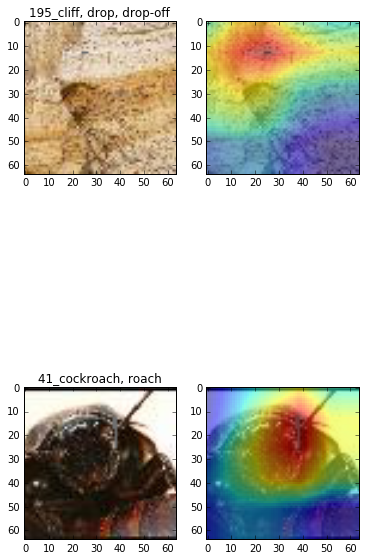

In [147]:
visualize_cam(X_rmded.astype(np.uint8), Y_sample, cam_list_sample, idx_word_dict, n_show=2, start=41)

# Evaluation

In [6]:
(cam_list_train,
bbox_list_train,
gt_known_loc_accuracy_train,
top_1_loc_accuracy_train) = evaluate(model, X_train, P_train, Y_train_one_hot, 'train')

GT-known-Loc train iou_accuracy : 0.4590125
Top-1 Loc train iou_accuracy : 0.292675


In [10]:
(cam_list_valid,
bbox_list_valid,
gt_known_loc_accuracy_valid,
top_1_loc_accuracy_valid) = evaluate(model, X_valid, P_valid, Y_valid_one_hot, 'valid')

GT-known-Loc valid iou_accuracy : 0.4652
Top-1 Loc valid iou_accuracy : 0.293


In [11]:
(cam_list_test,
bbox_list_test,
gt_known_loc_accuracy_test,
top_1_loc_accuracy_test) = evaluate(model, X_test, P_test, Y_test_one_hot, 'test')

GT-known-Loc test iou_accuracy : 0.4541
Top-1 Loc test iou_accuracy : 0.2863


# Visualization

(<matplotlib.figure.Figure at 0x7f8e4262e400>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8e42313e10>,
         <matplotlib.axes._subplots.AxesSubplot object at 0x7f8e421ce780>]], dtype=object))

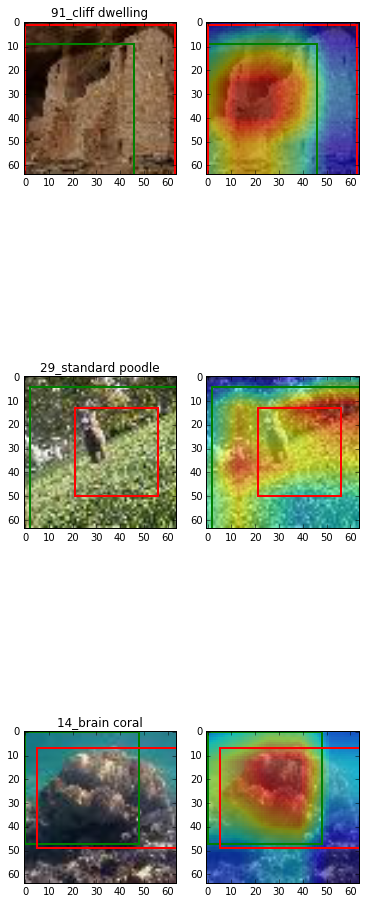

In [12]:
visualize(X_train, P_train, Y_train, cam_list_train, bbox_list_train, idx_word_dict,
          n_show=3, start=18)

(<matplotlib.figure.Figure at 0x7f8dac6c6780>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8e4212a198>,
         <matplotlib.axes._subplots.AxesSubplot object at 0x7f8dac47ec50>]], dtype=object))

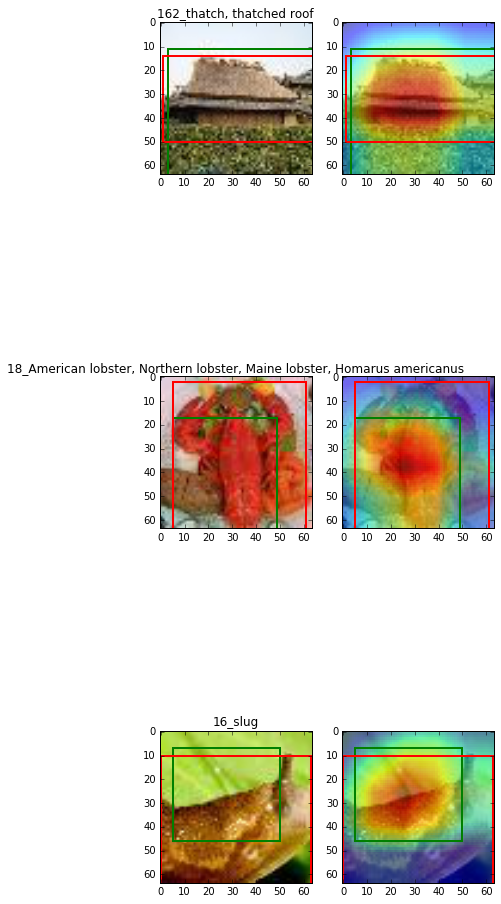

In [13]:
visualize(X_valid, P_valid, Y_valid, cam_list_valid, bbox_list_valid, idx_word_dict,
          n_show=3, start=0)

(<matplotlib.figure.Figure at 0x7f8dac3e00f0>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8dac60b1d0>,
         <matplotlib.axes._subplots.AxesSubplot object at 0x7f8dac082b38>]], dtype=object))

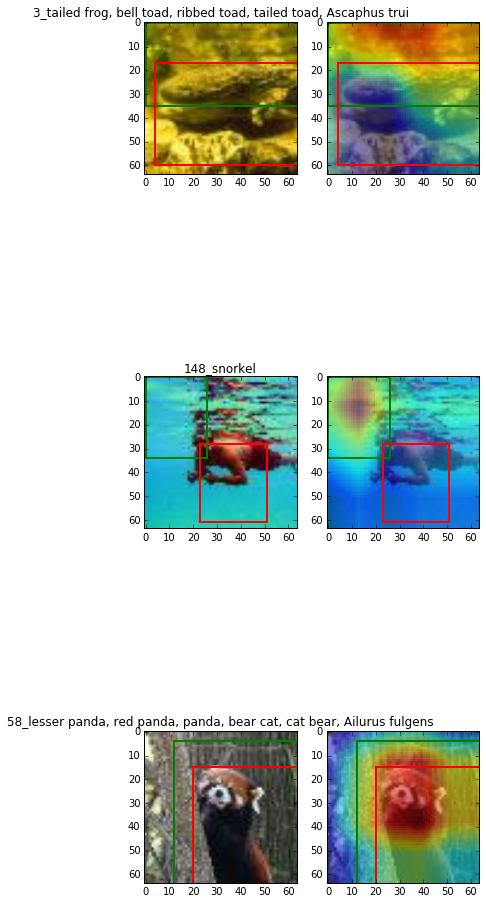

In [14]:
visualize(X_test, P_test, Y_test, cam_list_test, bbox_list_test, idx_word_dict,
          n_show=3, start=6)

- - -

# Accuracy

In [15]:
result = model.evaluate(X_train, Y_train_one_hot, batch_size=128)
print("train accuracy :{}". format(result[1]))
result = model.evaluate(X_valid, Y_valid_one_hot, batch_size=128)
print("valid accuracy :{}". format(result[1]))
result = model.evaluate(X_test, Y_test_one_hot, batch_size=128)
print("test accuracy :{}". format(result[1]))

train accuracy :0.5508625
valid accuracy :0.54335
test accuracy :0.5393
